In [ ]:
# Mount Google drive for save and load LSTM models if you're using colab 
# , and if your files are saved in Google drive
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')
    
else:
  print('Not running on Colab')

Running on Colab
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import time

In [ ]:
import time
from scipy.integrate import odeint
from scipy.optimize import minimize

In [ ]:
# Load model files (LSTM and MinMaxScaler)
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  # model = load_model('/content/drive/MyDrive/LSTM_MPC/FOPDT/model.h5')
  s1 = joblib.load('/content/drive/MyDrive/LSTM_MPC/FOPDT/s1.sav')
  s2 = joblib.load('/content/drive/MyDrive/LSTM_MPC/FOPDT/s2.sav')
  
else:
  print('Not running on Colab')
  # model = load_model('model.h5')
  s1 = joblib.load('s1.sav')
  s2 = joblib.load('s2.sav')

Running on Colab


In [ ]:
# Define process model (FOPDT)
def process_model(y,t,u,K,tau):
    # arguments
    #  y   = outputs
    #  t   = time
    #  u   = input value
    #  K   = process gain
    #  tau = process time constant

    # calculate derivative
    dydt = (-y + K * u)/tau

    return dydt

In [ ]:
def MPCobj(u_hat, y_hat, SP_hat, t_hat, u):
  # FOPDT Parameters
  K=1      # gain
  tau=2    # time constant

   
  for i in range(0, t_hat.shape[0]-1):
    sol = odeint(process_model,y_hat[i],t_hat[i:i+2],args=(u_hat[i],K,tau))
    y_hat[i+1] = sol[-1]
    # print(i)
    # print(t_hat[i:i+2])  
    
    u_hat0 = np.append(u, u_hat)

  Obj = np.sum((y_hat - SP_hat)**2) + np.sum(((u_hat0[1:] - u_hat0[0:-1])**2))

  pred["y_hat"] = y_hat
  pred["u_hat"] = u_hat
  return Obj

In [ ]:
# Values at time=k 
u = 0
y = 0
SP = 1

# Prediction Horizon length (for future)
P = 10

# Initial Values at time=k+ (prediction horizon) 
t_hat = np.linspace(0,P-1,P)
u_hat = np.ones_like(t_hat) * u
y_hat = np.ones_like(t_hat) * y
SP_hat = np.ones_like(t_hat) * SP

In [ ]:
pred = {
    "y_hat": np.ones_like(t_hat) * y,
    "u_hat":np.ones_like(t_hat) * u
    }

In [ ]:
t0 = time.time()
solution = minimize(MPCobj, u_hat, method='SLSQP',args=(y_hat, SP_hat, t_hat, u),options={'eps': 1e-08})
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

Runtime: 0.23 s


In [ ]:
print(solution)

     fun: 2.369226243654205
     jac: array([-1.61426428e-04, -6.74571510e-05, -7.66497976e-05, -8.36664071e-05,
       -8.79740725e-05, -8.80184814e-05, -8.15347789e-05, -6.67910172e-05,
       -4.54303262e-05,  5.24913446e-05])
 message: 'Optimization terminated successfully.'
    nfev: 142
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.72783327, 1.03966444, 1.12846494, 1.12019615, 1.08324017,
       1.04796451, 1.02390491, 1.01120262, 1.00678148, 1.00680771])


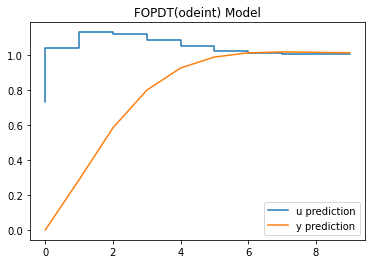

In [ ]:
plt.figure()
plt.title("FOPDT(odeint) Model")
plt.step(t_hat,pred["u_hat"], label='u prediction')
plt.plot(t_hat,pred["y_hat"], label='y prediction')
plt.legend()
plt.show()